In [1]:
#Importing useful libraries
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import greycomatrix
from skimage.feature import greycoprops
import random
from sklearn import preprocessing
import pandas as pd
from sklearn.svm import SVC
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import glob

#loading data
dataTrain = nib.load('tr_im.nii.gz')
dataMaskTrain = nib.load('tr_mask.nii.gz')

In [2]:
#function to show n images
def showImages(images, rows, cols):
    plt.figure(figsize = (16,16))
    for i in range (rows*cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap='gray',vmin=0, vmax=255)
        plt.title('Lung')
        plt.xticks(())
        plt.yticks(())

In [3]:
#function to convert the space or values of the original images into a new values
#using the original values. This is like a transformation from a matrix type float to
#uint8
def convert(img, targetTypeMin, targetTypeMax, targetType):
    imin = img.min()
    imax = img.max()

    a = (targetTypeMax - targetTypeMin) / (imax - imin)
    b = targetTypeMax - a * imax
    newImg = (a * img + b).astype(targetType)
    return newImg

In [4]:
#function to get the images into an numpy array of type int16
#our images are in the HU scale, so its not necessary convert it again!
def getImages(data):
    image = np.stack([data.get_fdata()[:,:,s] for s in range(data.shape[2])])
    image = image.astype(np.int16)
    return np.array(image, dtype=np.int16)

In [5]:
#getting data
train = getImages(dataTrain)
masks = getImages(dataMaskTrain)

#Coverting images
transf = []
for i in range(train.shape[0]):
    transformation = convert(train[i],np.iinfo(np.uint8).min,np.iinfo(np.uint8).max,np.uint8)
    transf.append(transformation)
train = np.array(transf)

In [6]:
#setting a seed to get reproducibility of data
np.random.seed(123)
#set an array of lenght 20 to randomly choose the image based on their index
rand = np.random.choice(100, 20, replace=False)
#set the test data based on the random numbers
test = train[rand]
#delete the images in test data from train
trainDel = np.delete(train,rand,axis=0)
#dividing mask data into test and train set using the same indexes
maskTest = masks[rand]
maskTrain = np.delete(masks,rand,axis=0)
#setting value levels depend on its class in the masktest data
maskTest[maskTest==1] = 128
maskTest[maskTest==2] = 192
maskTest[maskTest==3] = 255

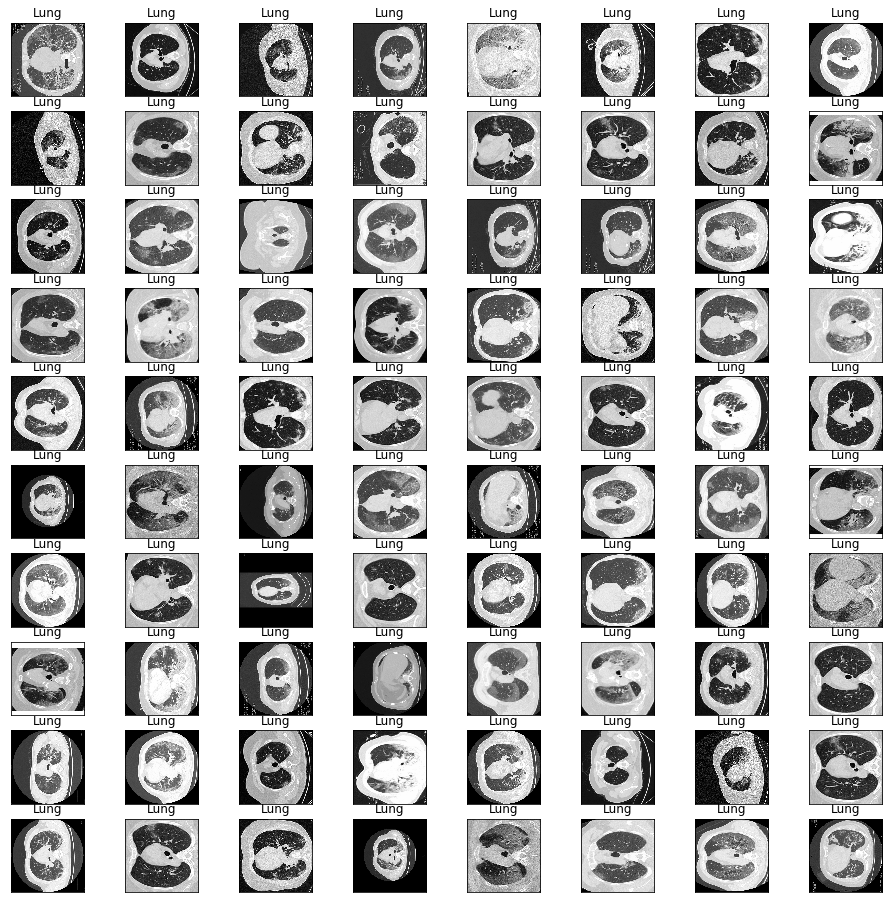

In [7]:
showImages(trainDel[0:80],10,8)

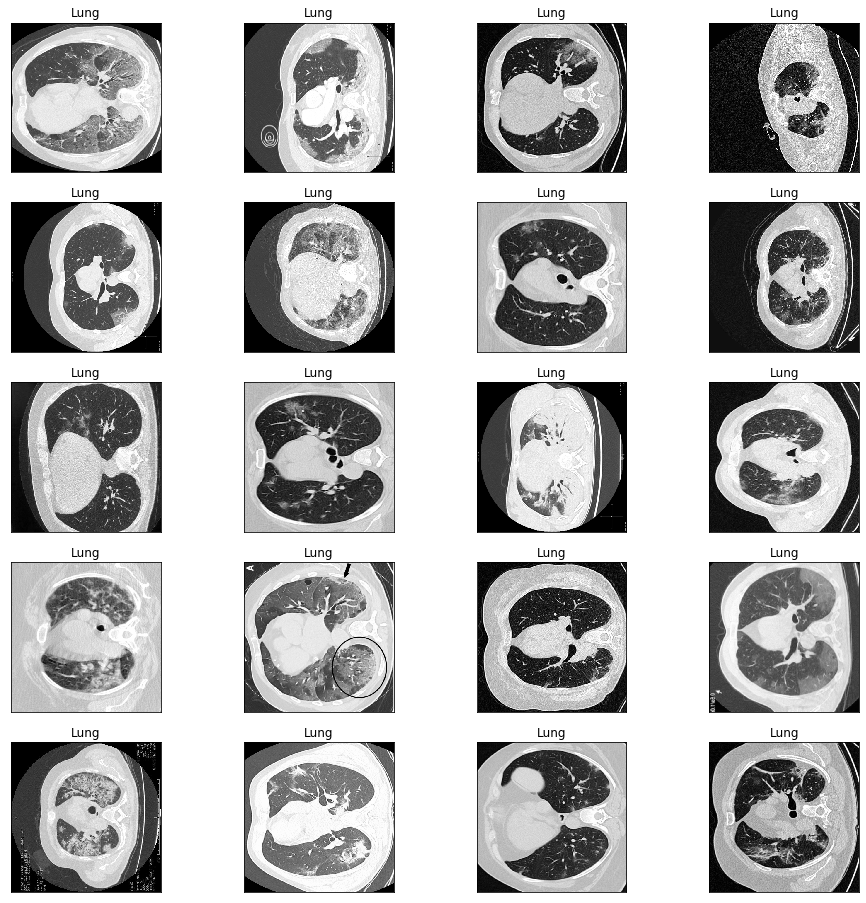

In [8]:
showImages(test[0:20],5,4)

In [9]:
#to train we need to get the real masks
listForType1 = []
listForType2 = []
listForType3 = []
for i in range(trainDel.shape[0]):
    for j in range(1,4,1):
        dataMaskTrain = nib.load('tr_mask.nii.gz')
        maskTrain = np.delete(masks,rand,axis=0)
        copy = maskTrain[i]
        index = np.where(copy!=j)
        copy[index]=0
        copy = copy/j
        if (len(index[0])==262144):
            continue
        masked = np.multiply(copy, trainDel[i])
        masked = masked.astype(np.uint8)
        if (j==1):
            listForType1.append(masked)
        elif (j==2):
            listForType2.append(masked)
        else:
            listForType3.append(masked)

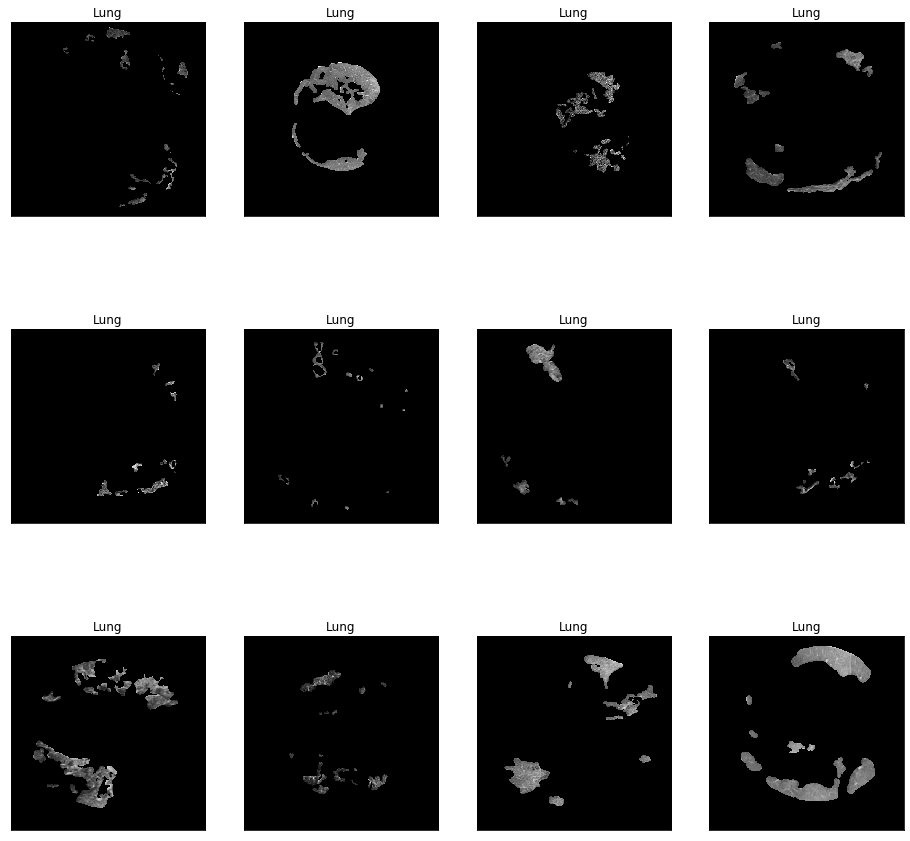

In [10]:
showImages(listForType1[6:18],3,4)

In [11]:
def getTextureProperties(maskedImages):
    propertyForType = np.zeros((len(maskedImages),6),dtype=float)
    for i in range(len(maskedImages)):
        GLCM = greycomatrix(maskedImages[i],distances=[1],angles=[0],symmetric=False,normed=True)
        GLCM = GLCM[1:,1:,:,:]
        contrast = greycoprops(GLCM,'contrast')
        dissimilarity = greycoprops(GLCM,'dissimilarity')
        homogeneity = greycoprops(GLCM,'homogeneity')
        asm = greycoprops(GLCM,'ASM')
        energy = greycoprops(GLCM,'energy')
        correlation = greycoprops(GLCM,'correlation')
        propertyForType[i] = (contrast,dissimilarity,homogeneity,asm,energy,correlation)
    return propertyForType

In [12]:
#instantiate the texture properties of each type (1,2,3) and preprocesing it using the function scale
#from scikit learn
type1 = getTextureProperties(listForType1)
type2 = getTextureProperties(listForType2)
type3 = getTextureProperties(listForType3)
#create dataframes from the texture properties
type1DataFrame = pd.DataFrame(type1)
type2DataFrame = pd.DataFrame(type2)
type3DataFrame = pd.DataFrame(type3)
#Add the classes to every dataFrame
type1DataFrame['Class'] = 1
type2DataFrame['Class'] = 2
type3DataFrame['Class'] = 3
#read the data from healthy lungs
healthy = pd.read_csv('healthy.csv',delimiter=',',header=None)
#Add column class to healthy dataFrame 
healthy['Class'] = 0
#create a list. With this list we can concatenate all dataframes 
frames = [healthy, type1DataFrame, type2DataFrame, type3DataFrame]
#concatenate all dfs
data = pd.concat(frames)
#set X variable as the obtained texture data
X = data.iloc[:,0:6].to_numpy()
#set Y variable as the classes
Y = data['Class'].to_numpy()

In [161]:
SVM = SVC(kernel='sigmoid',class_weight={0:0.9,1:1.4,2:1.4,3:0.97},decision_function_shape='ovr',probability=True)#,gamma='auto')#{0:1.2,1:1.32,2:1.61,3:1.8},{0:1,1:1.4,2:1.4,3:1}, Este no jala: {0:1.5,1:1.4,2:1.3,3:1}
SVM.fit(X,Y)

SVC(C=1.0, break_ties=False, cache_size=200,
    class_weight={0: 0.9, 1: 1.4, 2: 1.4, 3: 0.97}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

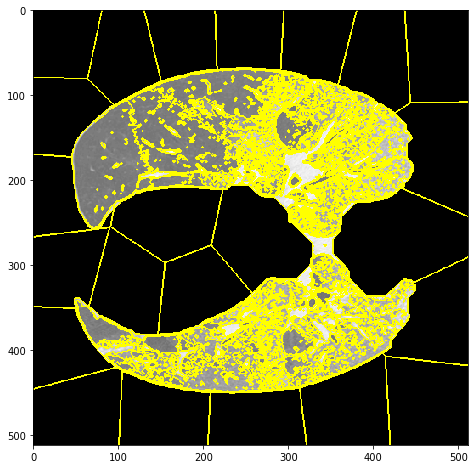

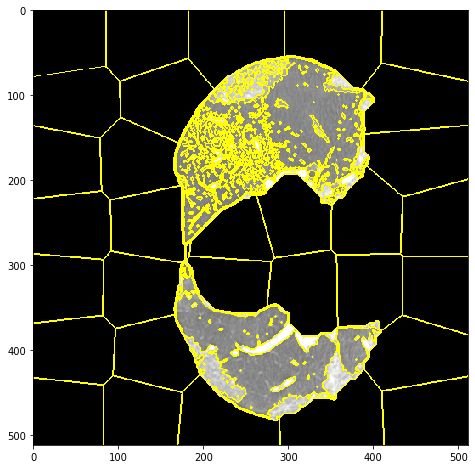

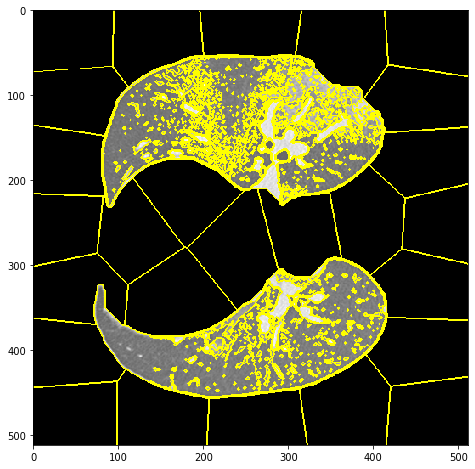

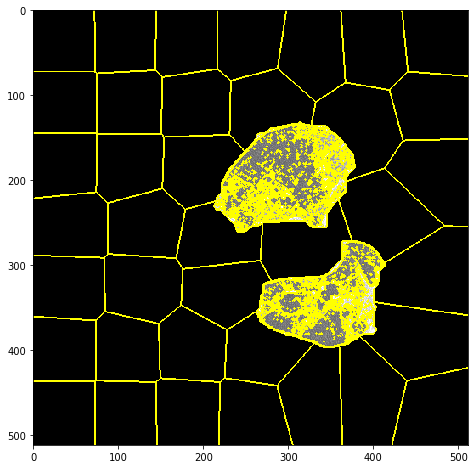

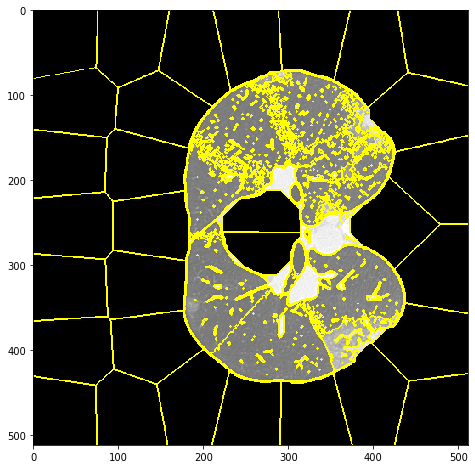

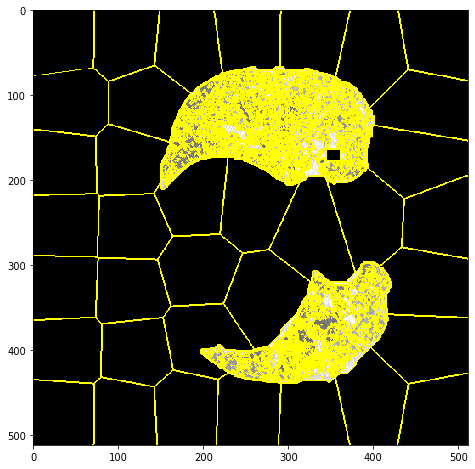

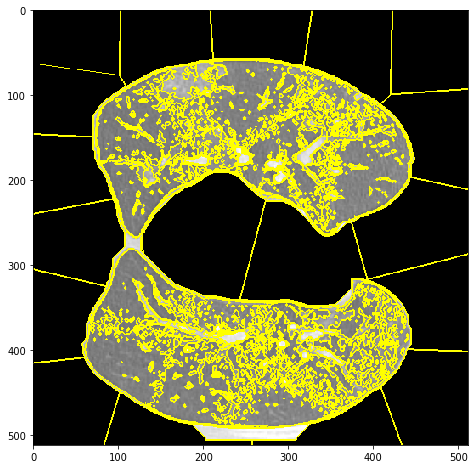

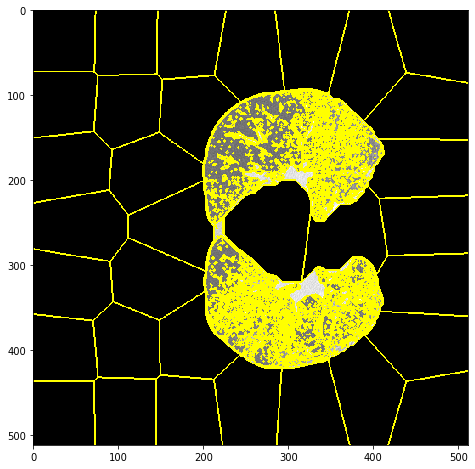

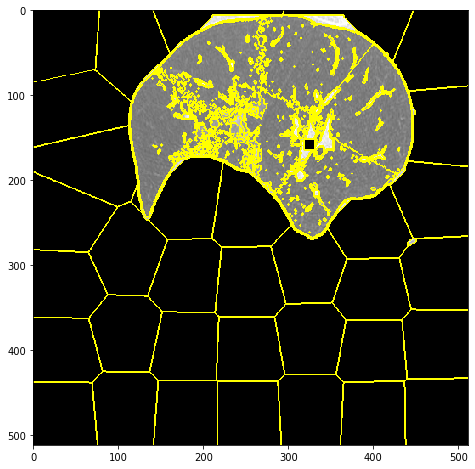

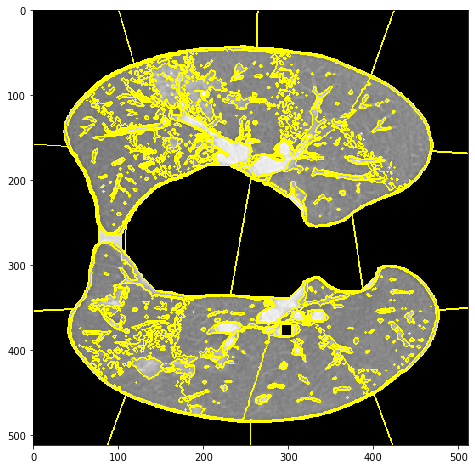

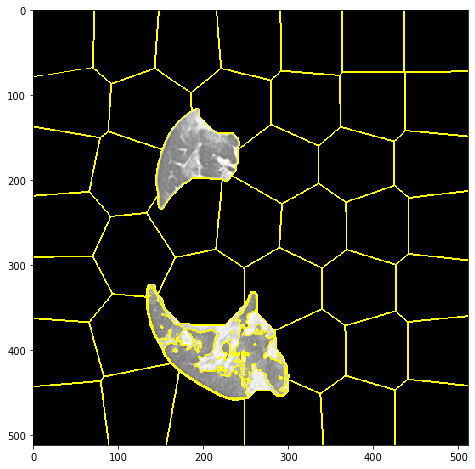

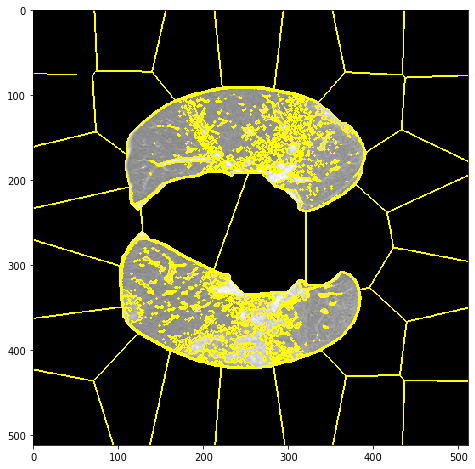

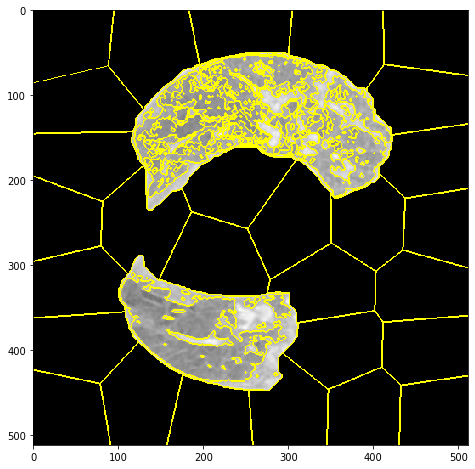

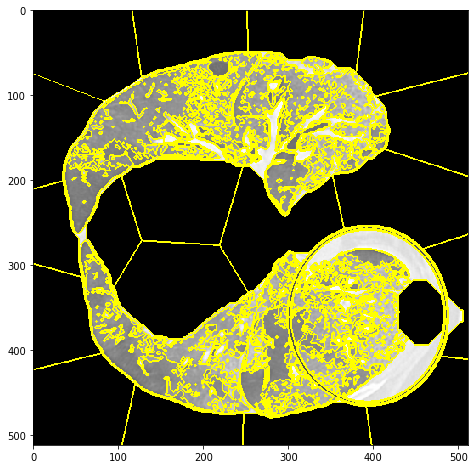

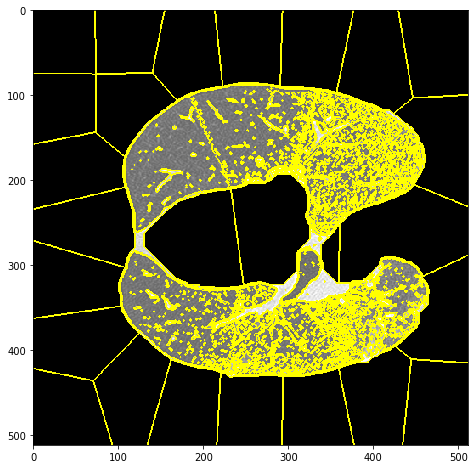

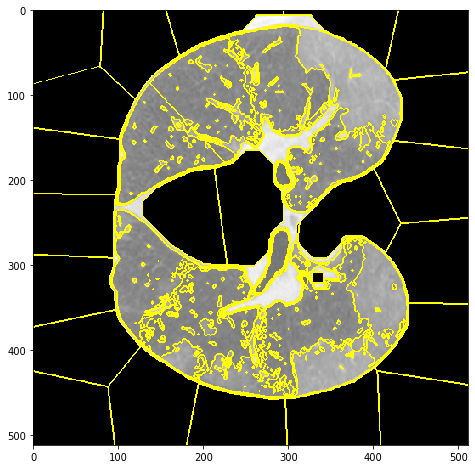

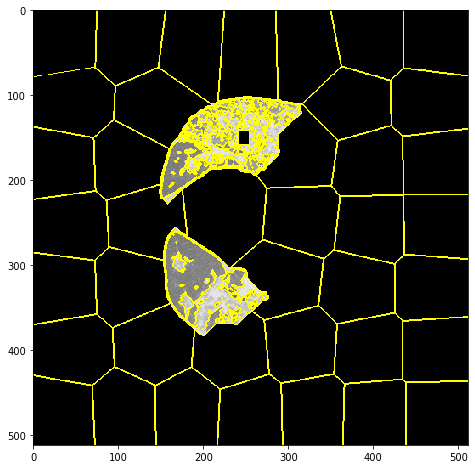

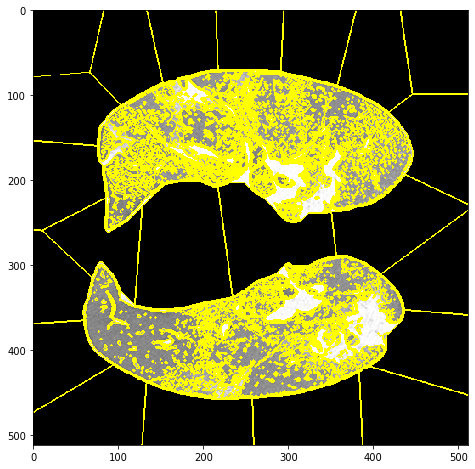

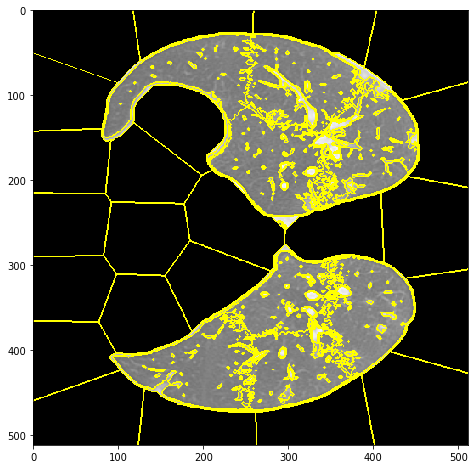

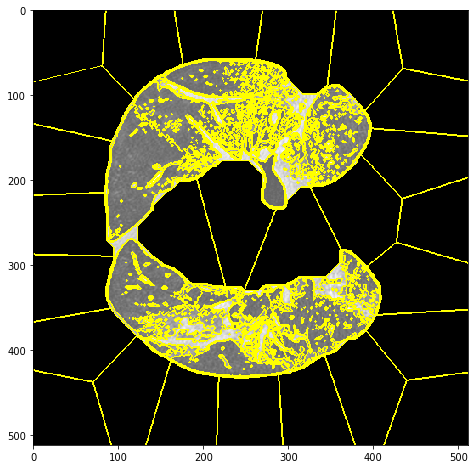

In [103]:
#testImages = [cv2.imread(file,0) for file in sorted(glob.glob("TrainWith/*.png"))]
testImages = []
for im in range(len(rand)):
    auxim = cv2.imread('TrainWith/'+str(im)+'.png',0)
    testImages.append(auxim)
read = []
for images in range(len(testImages)):
    image = cv2.cvtColor(testImages[images],cv2.COLOR_GRAY2BGR)
    read.append(image)
segmentedSlic = np.zeros((len(testImages),testImages[2].shape[0],testImages[2].shape[1]),dtype=np.uint8)    
for images in range(len(read)):
    segmented = slic(read[images], n_segments = 50, sigma=0,enforce_connectivity=False,compactness=5)
    segmentedSlic[images,:,:] = segmented
    fig = plt.figure("Superpixels -- %d segments"%(images),figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(read[images], segmented))    
plt.show()

In [38]:
#function to obtain the texture propierties of each masked image using the GLCM method
def wws(images,slicMatrix,predictor):
    data = []
    predictedImages = []
    #data = np.zeros((slicMatrix.shape[0],np.amax(segmentedSlic), 6),dtype=float)
    for i in range(len(images)):
        #auxdata = np.zeros((np.amax(segmentedSlic[i,:,:]), 6),dtype=float)
        auxdata = []
        predictedImage = np.zeros((images[i].shape),dtype=np.uint8)
        for j in range(np.amax(slicMatrix[i,:,:])+1):
            segment = np.where(slicMatrix[i,:,:]==j)
            auximage = np.zeros((images[i].shape[0],images[i].shape[1]),dtype=np.uint8)
            auximage[segment] = 1
            auximage = auximage*images[i]
            GLCM = greycomatrix(auximage,distances=[1],angles=[0],symmetric=False,normed=True)
            GLCM = GLCM[1:,1:,:,:]
            contrast = greycoprops(GLCM,'contrast')
            dissimilarity = greycoprops(GLCM,'dissimilarity')
            homogeneity = greycoprops(GLCM,'homogeneity')
            asm = greycoprops(GLCM,'ASM')
            energy = greycoprops(GLCM,'energy')
            correlation = greycoprops(GLCM,'correlation')
            if (contrast and dissimilarity and homogeneity !=0):
                auxvar = (contrast,dissimilarity,homogeneity,asm,energy,correlation)
                auxdata.append(auxvar)
                auxvar1 = np.array(auxvar)
                auxvar1 = auxvar1.reshape(1,-1)
                prediction = predictor.predict(auxvar1)[0]
                #print(prediction)
                if prediction == 0:
                    predictedImage[segment] = 0
                elif prediction == 1:
                    predictedImage[segment] = 128
                elif prediction == 2:
                    predictedImage[segment] = 192
                else:
                    predictedImage[segment] = 255
        auxdata = np.array(auxdata)
        #print(auxdata[:,:,0,0].shape)
        data.append(auxdata[:,:,0,0])
        predictedImages.append(predictedImage)
    return data, predictedImages

In [162]:
data, ims = wws(testImages,segmentedSlic,SVM)

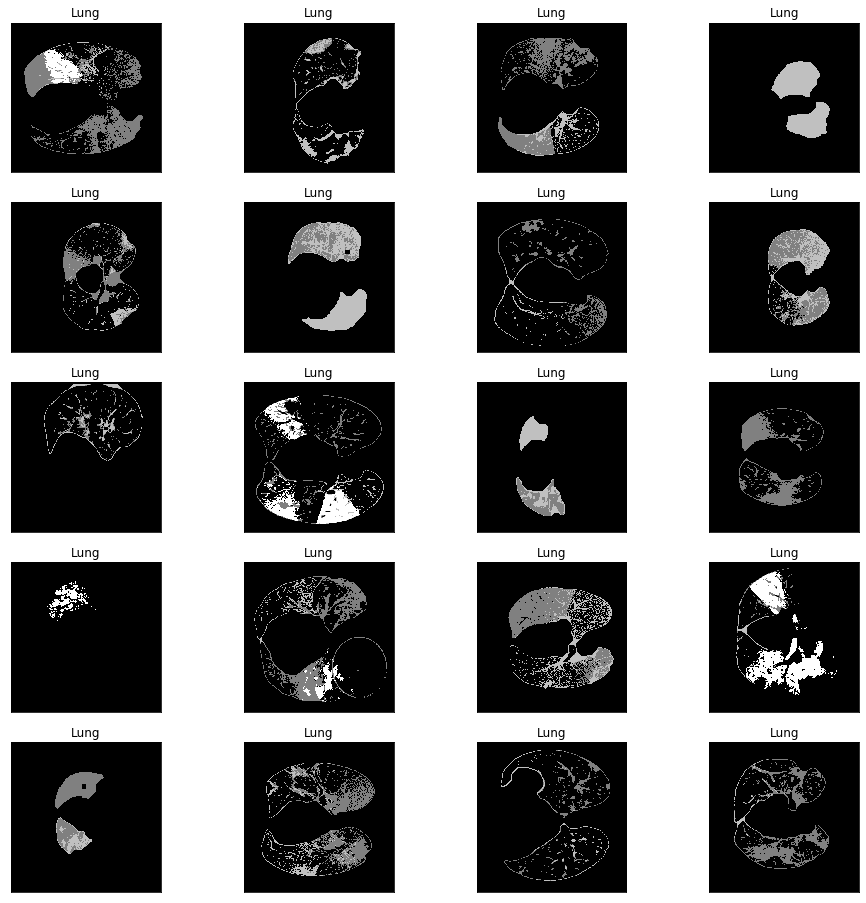

In [163]:
showImages(ims,5,4)

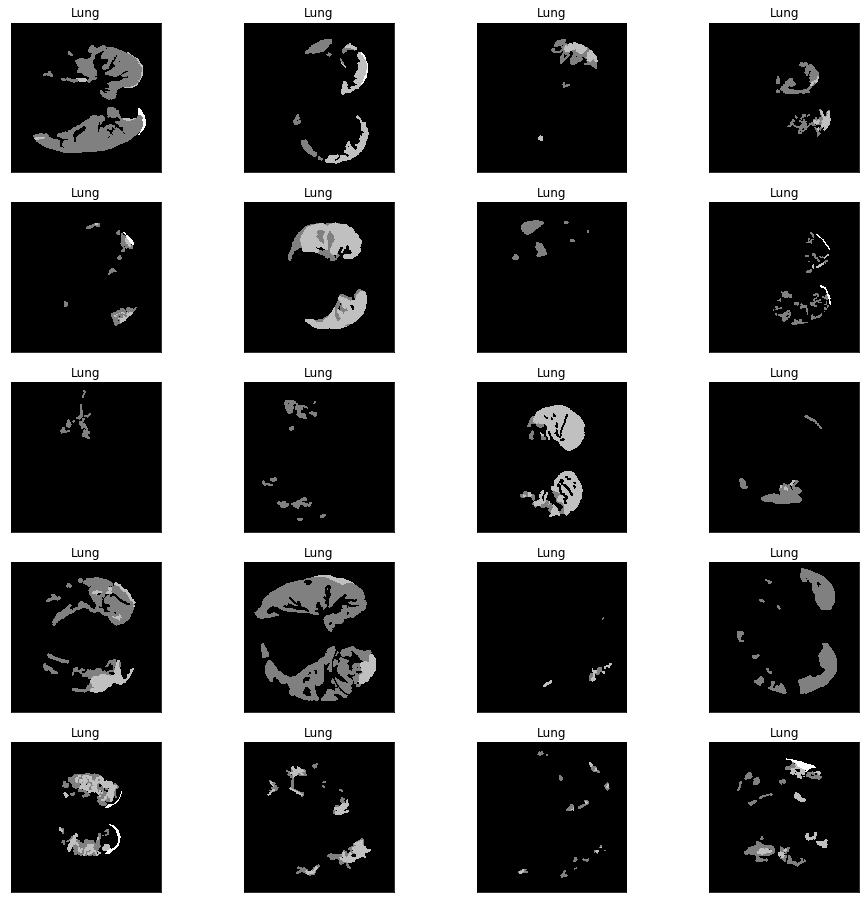

In [22]:
showImages(maskTest,5,4)

In [172]:
scaler = preprocessing.StandardScaler().fit(X)
scaled = scaler.transform(X)
SVM1 = SVC(kernel='sigmoid',class_weight={0:0.9,1:1.4,2:1.4,3:0.97},decision_function_shape='ovr',probability=True)#,gamma='auto')#{0:1.2,1:1.32,2:1.61,3:1.8},{0:1,1:1.4,2:1.4,3:1}, Este no jala: {0:1.5,1:1.4,2:1.3,3:1}
SVM1.fit(scaled,Y)
#function to obtain the texture propierties of each masked image using the GLCM method
def wws(images,slicMatrix,predictor):
    data = []
    predictedImages = []
    #data = np.zeros((slicMatrix.shape[0],np.amax(segmentedSlic), 6),dtype=float)
    for i in range(len(images)):
        #auxdata = np.zeros((np.amax(segmentedSlic[i,:,:]), 6),dtype=float)
        auxdata = []
        predictedImage = np.zeros((images[i].shape),dtype=np.uint8)
        for j in range(np.amax(slicMatrix[i,:,:])+1):
            segment = np.where(slicMatrix[i,:,:]==j)
            auximage = np.zeros((images[i].shape[0],images[i].shape[1]),dtype=np.uint8)
            auximage[segment] = 1
            auximage = auximage*images[i]
            GLCM = greycomatrix(auximage,distances=[1],angles=[0],symmetric=False,normed=True)
            GLCM = GLCM[1:,1:,:,:]
            contrast = greycoprops(GLCM,'contrast')
            dissimilarity = greycoprops(GLCM,'dissimilarity')
            homogeneity = greycoprops(GLCM,'homogeneity')
            asm = greycoprops(GLCM,'ASM')
            energy = greycoprops(GLCM,'energy')
            correlation = greycoprops(GLCM,'correlation')
            if (contrast and dissimilarity and homogeneity !=0):
                auxvar = (contrast,dissimilarity,homogeneity,asm,energy,correlation)
                auxdata.append(auxvar)
                auxvar1 = np.array(auxvar)
                auxvar1 = auxvar1.reshape(1,-1)
                auxvar1 = scaler.transform(auxvar1)
                prediction = predictor.predict(auxvar1)[0]
                #print(prediction)
                if prediction == 0:
                    predictedImage[segment] = 0
                elif prediction == 1:
                    predictedImage[segment] = 128
                elif prediction == 2:
                    predictedImage[segment] = 192
                else:
                    predictedImage[segment] = 255
        auxdata = np.array(auxdata)
        #print(auxdata[:,:,0,0].shape)
        data.append(auxdata[:,:,0,0])
        predictedImages.append(predictedImage)
    return data, predictedImages

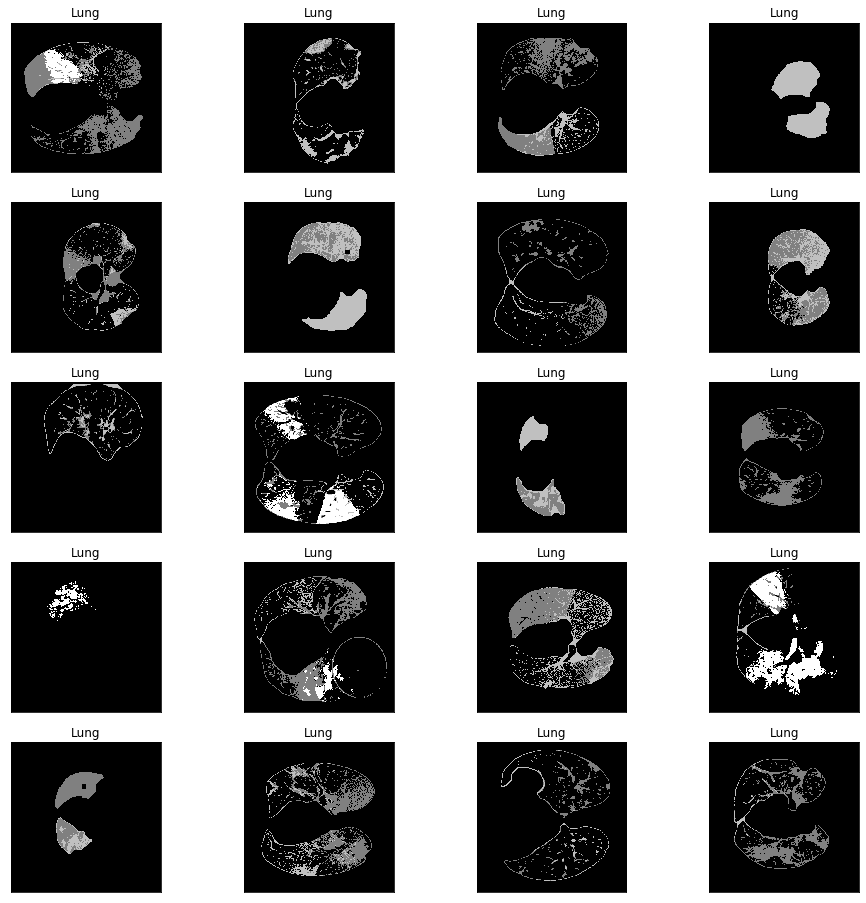

In [174]:
data1, ims1 = wws(testImages,segmentedSlic,SVM1)
showImages(ims,5,4)

## The classification using scaled data is the same as the non-scaled data.
# End of code C: